In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

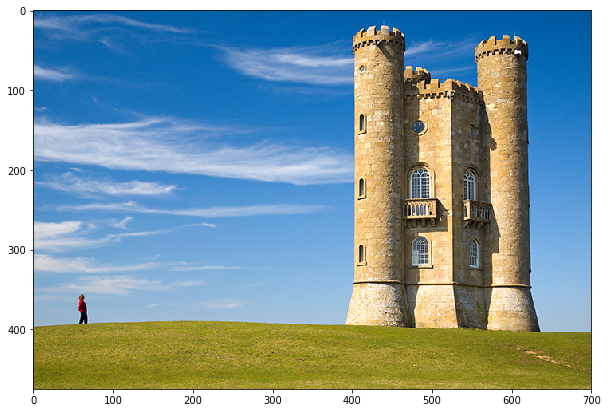

In [53]:
img = cv2.imread("public_data/01_input/img.png")
plt.figure(figsize=(10, 10))
plt.imshow(img[:,:,::-1]);

In [39]:
def energy(img):
    brightness = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)[:,:,0]
    derivative_x = np.vstack((brightness[1:2] - brightness[:1],
                              brightness[2:] - brightness[:-2],
                              brightness[-1:] - brightness[-2:-1]))
    derivative_y = np.hstack((brightness[:,1:2] - brightness[:,:1],
                              brightness[:,2:] - brightness[:,:-2],
                              brightness[:,-1:] - brightness[:,-2:-1]))
    return np.sqrt(derivative_x ** 2 + derivative_y ** 2)

def carve_seam(img, direction="horizontal"):
    if direction == "vertical":
        img = img.transpose(1, 0, 2)
    enrg = energy(img)
    cum = enrg.copy()
    for i in range(1, cum.shape[0]):
        for j in range(1, cum.shape[1] - 1):
            cum[i, j] += np.min(cum[i - 1, j - 1: j + 2])
        cum[i, 0] += np.min(cum[i - 1, :2])
        cum[i, -1] += np.min(cum[i - 1, -2:])
    
    # Build and carve seam simultaneously
    seam = np.zeros_like(cum, dtype=np.uint8)
    seam_y = np.argmin(cum[-1])
    seam[-1, seam_y] = 1
    img = list(img)
    img[-1] = np.concatenate((img[-1][:seam_y], img[-1][seam_y + 1:]), axis=0)
    for i in range(cum.shape[0] - 2, -1, -1):
        seam_y = np.argmin(cum[i, max(0, seam_y - 1): min(cum.shape[1], seam_y + 2)]) + max(0, seam_y - 1)
        seam[i, seam_y] = 1
        img[i] = np.concatenate((img[i][:seam_y], img[i][seam_y + 1:]), axis=0)
    
    img = np.array(img)
    if direction == "vertical":
        img = img.transpose(1, 0, 2)
    return img

In [47]:
from tqdm import tqdm

img_ = img.copy()
for _ in tqdm(range(300)):
    img_ = carve_seam(img_)

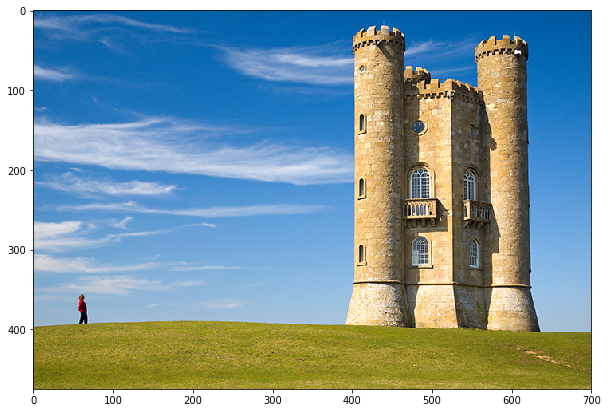

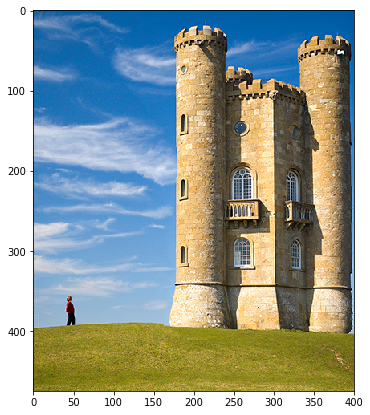

In [46]:
plt.figure(figsize=(10, 10))
plt.imshow(img[:,:,::-1])
plt.figure(figsize=(10, 7))
plt.imshow(img_[:,:,::-1])

---

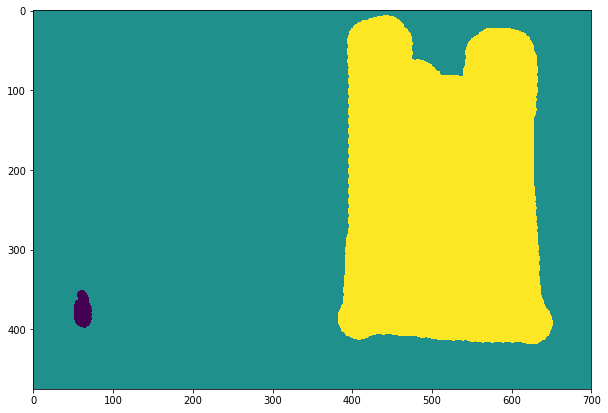

In [151]:
def convert_img_to_mask(img):
    return ((img[:, :, 0] != 0) * -1 + (img[:, :, 1] != 0)).astype('int8')

mask = cv2.imread("public_data/01_input/mask.png")
m = convert_img_to_mask(mask)
m = np.zeros_like(mask[:,:,0], dtype=np.int8)
m[np.where(mask[:,:,1])] = 1
m[np.where(mask[:,:,2])] = -1
plt.figure(figsize=(10, 10))
plt.imshow(m);

In [158]:
def brightness_channel(bgr):
    bgr = bgr.astype(np.float32)
    return 0.299 * bgr[:,:,2] + 0.587 * bgr[:,:,1] + 0.114 * bgr[:,:,0]

def energy(img):
#     brightness = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)[:,:,0].astype(np.float32)
    brightness = brightness_channel(img)
    derivative_x = np.vstack((brightness[1:2] - brightness[:1],
                              brightness[2:] - brightness[:-2],
                              brightness[-1:] - brightness[-2:-1]))
    derivative_y = np.hstack((brightness[:,1:2] - brightness[:,:1],
                              brightness[:,2:] - brightness[:,:-2],
                              brightness[:,-1:] - brightness[:,-2:-1]))
    return np.sqrt(derivative_x ** 2 + derivative_y ** 2)

In [159]:
def seam_carve(img, mode="horizontal shrink", mask=None):
    direction, action = mode.split()
    if direction == "vertical":
        img = img.transpose(1, 0, 2)
        mask = mask.transpose(1, 0)
    
    cum = energy(img)
    if mask is not None:
        delta = mask.shape[0] * mask.shape[1] * 256
        cum[mask == 1] += delta
        cum[mask == -1] -= delta
    for i in range(1, cum.shape[0]):
        for j in range(1, cum.shape[1] - 1):
            cum[i, j] += np.min(cum[i - 1, j - 1: j + 2])
        cum[i, 0] += np.min(cum[i - 1, :2])
        cum[i, -1] += np.min(cum[i - 1, -2:])
    
    # Build and carve seam simultaneously
    seam = []
    seam_y = np.argmin(cum[-1])
    img = list(img)
    if action == "shrink":
        img[-1] = np.concatenate((img[-1][:seam_y], img[-1][seam_y + 1:]), axis=0)
    else:
        img[-1] = np.concatenate((img[-1][:seam_y + 1],
                                 img[-1][seam_y: seam_y + 2].mean(axis=0).reshape(1, -1).astype(img[-1].dtype),
                                 img[-1][seam_y + 1:]),
                                axis=0)
    seam.append(np.zeros_like(img[-1][:,0], dtype=np.uint8))
    seam[-1][seam_y] = 1
        
    for i in range(cum.shape[0] - 2, -1, -1):
        seam_y = np.argmin(cum[i, max(0, seam_y - 1): min(cum.shape[1], seam_y + 2)]) + max(0, seam_y - 1)
        if action == "shrink":
            img[i] = np.concatenate((img[i][:seam_y],
                                     img[i][seam_y + 1:]),
                                    axis=0)
        else:
            img[i] = np.concatenate((img[i][:seam_y + 1],
                                     img[i][seam_y: seam_y + 2].mean(axis=0).reshape(1, -1).astype(img[-1].dtype),
                                     img[i][seam_y + 1:]),
                                    axis=0)
        seam.append(np.zeros_like(img[i][:,0], dtype=np.uint8))
        seam[-1][seam_y] = 1

    img = np.array(img)
    seam = np.array(seam[::-1])
        
    if direction == "vertical":
        img = img.transpose(1, 0, 2)
        mask = mask.transpose(1, 0)
        seam = seam.transpose(1, 0)

    return img, mask, seam

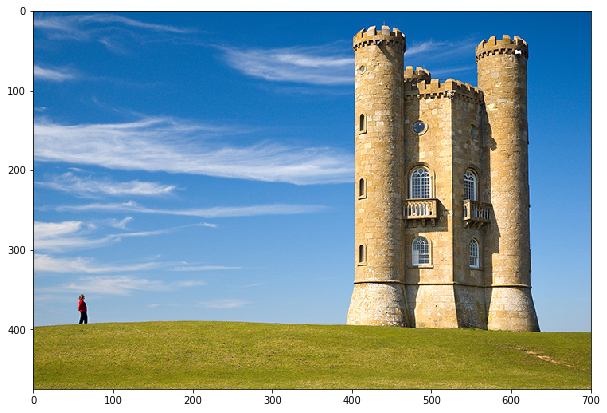

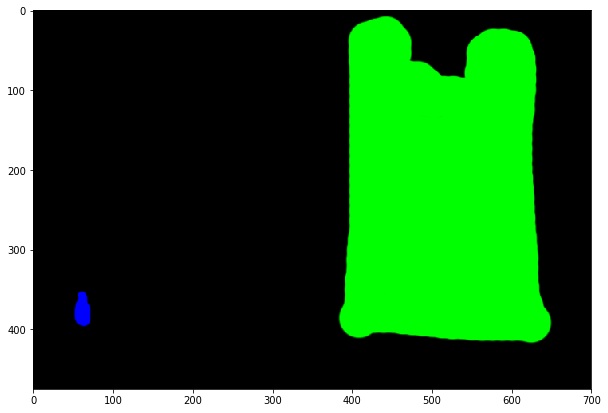

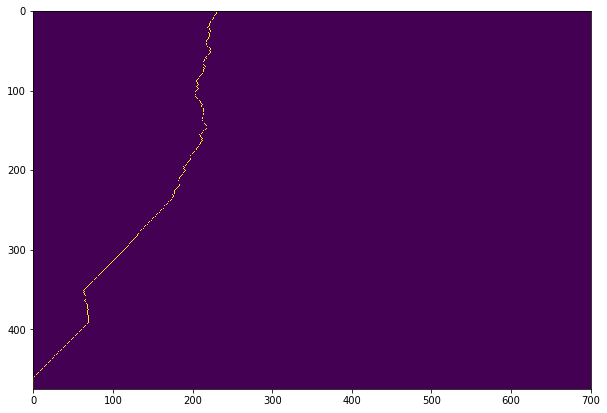

In [160]:
img_new, m_new, seam = seam_carve(img, "horizontal expand", m)
plt.figure(figsize=(10, 10))
plt.imshow(img_new[:,:,::-1])
plt.figure(figsize=(10, 10))
plt.imshow(mask)
plt.figure(figsize=(10, 10))
plt.imshow(seam);

In [253]:
from os.path import join
from pickle import load

# with open(join('public_data/01_output', 'output_seams'), 'rb') as fout, \
#      open(join('public_data/01_gt', 'seams'), 'rb') as fgt:
with open(join('small_data/02_output', 'output_seams'), 'rb') as fout, \
     open(join('small_data/02_gt', 'seams'), 'rb') as fgt:
    for i in range(6):
        pred = load(fout)
        exp = load(fgt)

In [255]:
print(pred[-3:])
print(exp[-3:])

((466, 698), (467, 665), (467, 699))
((467, 667), (467, 669), (467, 699))


In [250]:
seam_pred = np.zeros_like(img, dtype=np.int8)
for ind in pred:
    seam_pred[ind + (1,)] = 1
for ind in exp:
    seam_pred[ind + (2,)] = 1
# seam_true = np.zeros_like(img[:,:,0])

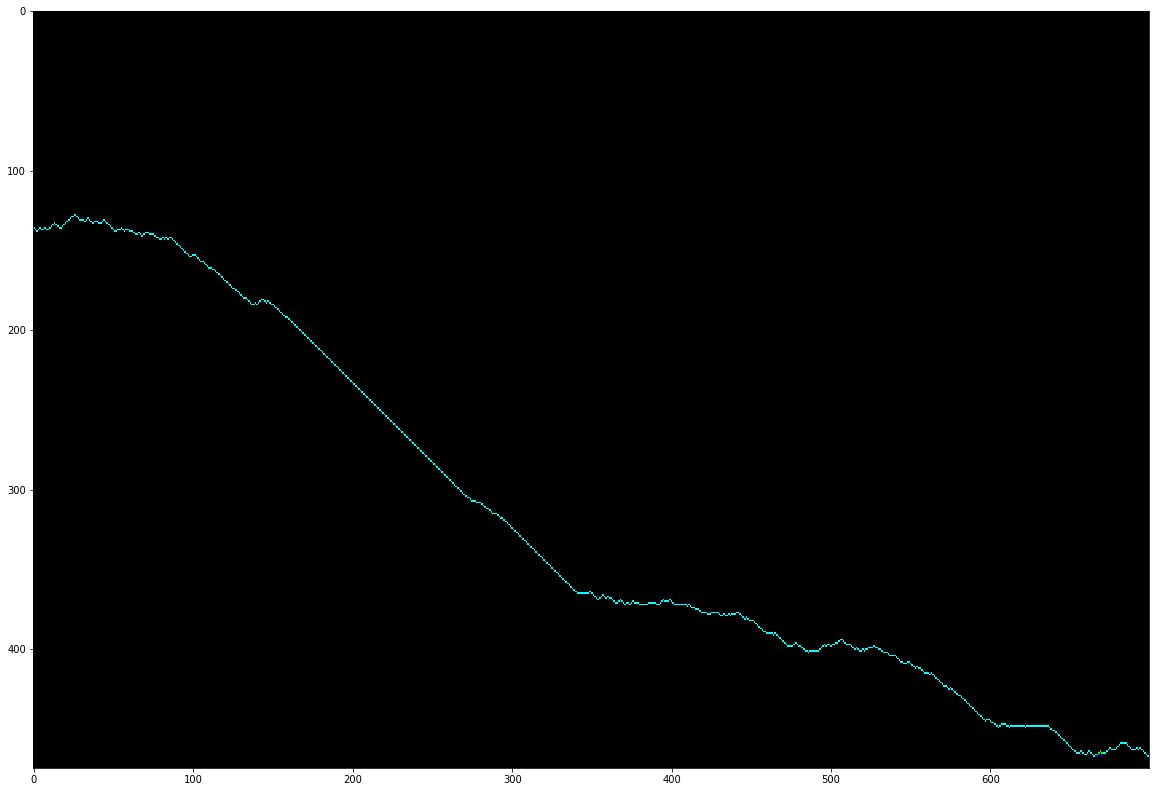

In [251]:
plt.figure(figsize=(20, 20))
plt.imshow(seam_pred);

In [252]:
for i, p in enumerate(list(zip(pred, exp))):
    print(i, p[0], p[1], p[0] == p[1])

0 (128, 26) (128, 26) True
1 (129, 24) (129, 24) True
2 (129, 25) (129, 25) True
3 (129, 27) (129, 27) True
4 (130, 23) (130, 23) True
5 (130, 28) (130, 28) True
6 (130, 34) (130, 34) True
7 (131, 22) (131, 22) True
8 (131, 29) (131, 29) True
9 (131, 30) (131, 30) True
10 (131, 31) (131, 31) True
11 (131, 33) (131, 33) True
12 (131, 35) (131, 35) True
13 (131, 44) (131, 44) True
14 (132, 21) (132, 21) True
15 (132, 32) (132, 32) True
16 (132, 36) (132, 36) True
17 (132, 38) (132, 38) True
18 (132, 39) (132, 39) True
19 (132, 40) (132, 40) True
20 (132, 43) (132, 43) True
21 (132, 45) (132, 45) True
22 (133, 13) (133, 13) True
23 (133, 20) (133, 20) True
24 (133, 37) (133, 37) True
25 (133, 41) (133, 41) True
26 (133, 42) (133, 42) True
27 (133, 46) (133, 46) True
28 (134, 12) (134, 12) True
29 (134, 14) (134, 14) True
30 (134, 19) (134, 19) True
31 (134, 47) (134, 47) True
32 (135, 11) (135, 11) True
33 (135, 15) (135, 15) True
34 (135, 18) (135, 18) True
35 (135, 48) (135, 48) True
36

474 (395, 508) (395, 508) True
475 (396, 471) (396, 471) True
476 (396, 478) (396, 478) True
477 (396, 503) (396, 503) True
478 (396, 504) (396, 504) True
479 (396, 509) (396, 509) True
480 (397, 472) (397, 472) True
481 (397, 477) (397, 477) True
482 (397, 479) (397, 479) True
483 (397, 496) (397, 496) True
484 (397, 498) (397, 498) True
485 (397, 499) (397, 499) True
486 (397, 501) (397, 501) True
487 (397, 502) (397, 502) True
488 (397, 510) (397, 510) True
489 (397, 511) (397, 511) True
490 (397, 512) (397, 512) True
491 (398, 473) (398, 473) True
492 (398, 474) (398, 474) True
493 (398, 475) (398, 475) True
494 (398, 476) (398, 476) True
495 (398, 480) (398, 480) True
496 (398, 481) (398, 481) True
497 (398, 495) (398, 495) True
498 (398, 497) (398, 497) True
499 (398, 500) (398, 500) True
500 (398, 513) (398, 513) True
501 (398, 527) (398, 527) True
502 (399, 482) (399, 482) True
503 (399, 494) (399, 494) True
504 (399, 514) (399, 514) True
505 (399, 516) (399, 516) True
506 (399